In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, mean_absolute_error, r2_score, ConfusionMatrixDisplay,confusion_matrix, recall_score

In [2]:
# Importing from the data source

df = pd.read_excel("airbnb.xlsx")
df.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaT,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaT,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaT,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,2008-06-26,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,2008-06-26,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [3]:
print(f'Dataset has {len(df.columns)} and {len(df.index)} entries')

Dataset has 13 and 30478 entries


In [4]:
df.columns

Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood ', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating'],
      dtype='object')

In [5]:
df['Review Scores Rating (bin)'].unique()

# The quality is evaluated range from 3 to 8 in this dataset

array([ nan,  95., 100.,  90.,  85.,  80.,  75.,  65.,  70.,  60.,  40.,
        50.,  20.,  55.,  45.,  30.])

In [6]:
for column in df.columns:
    print(f"Type of {column}: {type(df[column][0])}")

Type of Host Id: <class 'numpy.int64'>
Type of Host Since: <class 'pandas._libs.tslibs.nattype.NaTType'>
Type of Name: <class 'str'>
Type of Neighbourhood : <class 'str'>
Type of Property Type: <class 'str'>
Type of Review Scores Rating (bin): <class 'numpy.float64'>
Type of Room Type: <class 'str'>
Type of Zipcode: <class 'numpy.float64'>
Type of Beds: <class 'numpy.float64'>
Type of Number of Records: <class 'numpy.int64'>
Type of Number Of Reviews: <class 'numpy.int64'>
Type of Price: <class 'numpy.int64'>
Type of Review Scores Rating: <class 'numpy.float64'>


In [7]:
df.describe()

,Host Id,Host Since,Review Scores Rating (bin),Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
count,3.047800e+04,30475,22155.000000,30344.000000,30393.000000,30478.0,30478.000000,30478.000000,22155.000000
mean,1.273171e+07,2013-06-29 17:56:15.317473280,90.738659,10584.854831,1.530089,1.0,12.018735,163.589737,91.993230
min,5.000000e+02,2008-06-26 00:00:00,20.000000,1003.000000,0.000000,1.0,0.000000,10.000000,20.000000
25%,2.701298e+06,2012-06-21 00:00:00,85.000000,10017.000000,1.000000,1.0,0.000000,80.000000,89.000000
50%,8.551693e+06,2013-09-01 00:00:00,90.000000,10065.000000,1.000000,1.0,3.000000,125.000000,94.000000
75%,2.120617e+07,2014-09-12 00:00:00,100.000000,11216.000000,2.000000,1.0,13.000000,195.000000,100.000000
max,4.303307e+07,2015-08-31 00:00:00,100.000000,99135.000000,16.000000,1.0,257.000000,10000.000000,100.000000
std,1.190270e+07,NaN,9.059519,921.299397,1.015359,0.0,21.980703,197.785454,8.850373


In [8]:
# null check
df.isna().sum()

Host Id                          0
Host Since                       3
Name                             0
Neighbourhood                    0
Property Type                    3
Review Scores Rating (bin)    8323
Room Type                        0
Zipcode                        134
Beds                            85
Number of Records                0
Number Of Reviews                0
Price                            0
Review Scores Rating          8323
dtype: int64

In [9]:
raw = df.fillna(0)

In [10]:
raw.isna().sum()

Host Id                       0
Host Since                    0
Name                          0
Neighbourhood                 0
Property Type                 0
Review Scores Rating (bin)    0
Room Type                     0
Zipcode                       0
Beds                          0
Number of Records             0
Number Of Reviews             0
Price                         0
Review Scores Rating          0
dtype: int64

,count
Review Scores Rating (bin),
20.0,39
30.0,2
40.0,49
45.0,4
50.0,27
55.0,7
60.0,258
65.0,96
70.0,301


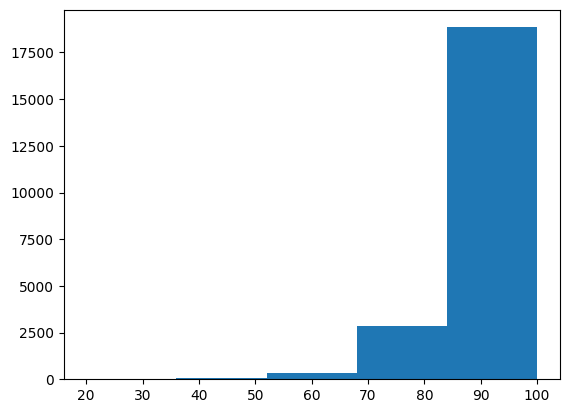

In [11]:
# without having any fe


import matplotlib.pyplot as plt
plt.hist(df["Review Scores Rating (bin)"], bins=5)
display(df.groupby("Review Scores Rating (bin)").agg(count=("Review Scores Rating (bin)", "count"))) # 5~6 are the decent wine while qualit > 6 is high quality, qualtiy < 5 is low .


In [12]:
from sklearn.preprocessing import LabelEncoder
quality_encoder = LabelEncoder()
quality_encoder.fit(df["Review Scores Rating (bin)"].unique())
df.loc[:, "Review Scores Rating_encoded"] = quality_encoder.transform(df["Review Scores Rating (bin)"])
quality_encoder.classes_

array([ 20.,  30.,  40.,  45.,  50.,  55.,  60.,  65.,  70.,  75.,  80.,
        85.,  90.,  95., 100.,  nan])

In [13]:
raw.describe()

,Host Id,Review Scores Rating (bin),Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
count,3.047800e+04,30478.000000,30478.000000,30478.000000,30478.0,30478.000000,30478.000000,30478.000000
mean,1.273171e+07,65.959545,10538.317311,1.525822,1.0,12.018735,163.589737,66.871514
std,1.190270e+07,41.159856,1155.640036,1.017148,0.0,21.980703,197.785454,41.676377
min,5.000000e+02,0.000000,0.000000,0.000000,1.0,0.000000,10.000000,0.000000
25%,2.701298e+06,0.000000,10016.000000,1.000000,1.0,0.000000,80.000000,0.000000
50%,8.551693e+06,90.000000,10065.000000,1.000000,1.0,3.000000,125.000000,90.000000
75%,2.120617e+07,95.000000,11216.000000,2.000000,1.0,13.000000,195.000000,97.000000
max,4.303307e+07,100.000000,99135.000000,16.000000,1.0,257.000000,10000.000000,100.000000


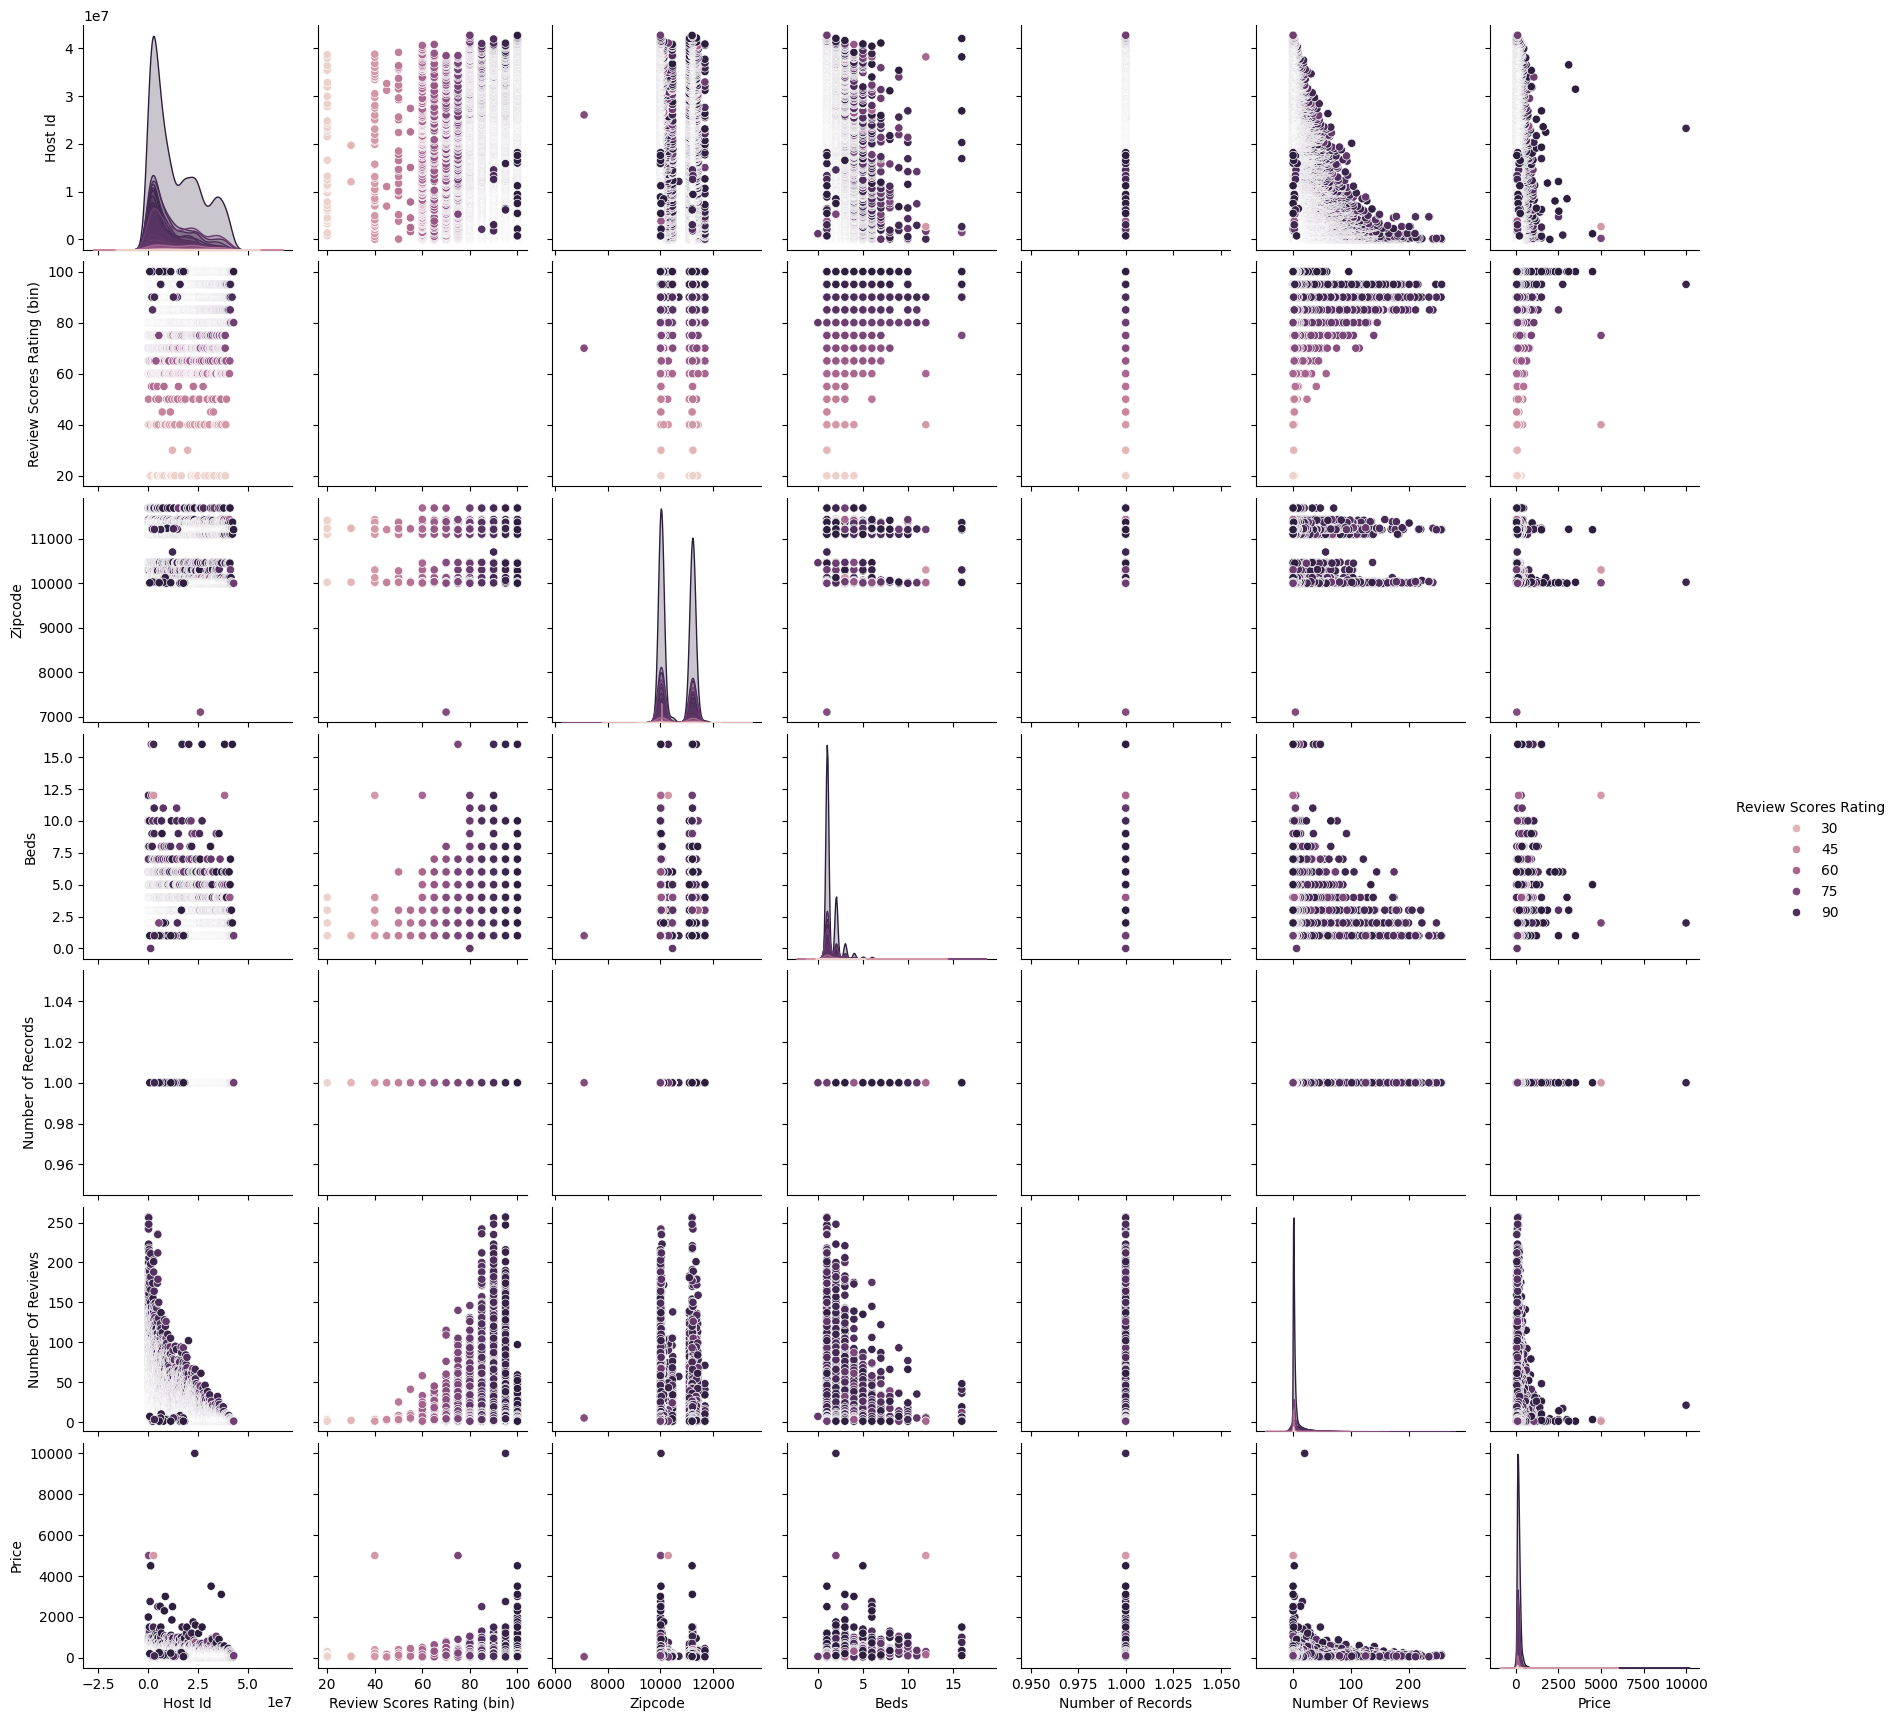

In [14]:
import seaborn as sn 
sn.pairplot(df[['Host Id', 'Review Scores Rating (bin)', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price', 'Review Scores Rating']], hue="Review Scores Rating")

<Axes: xlabel='Number Of Reviews', ylabel='Number Of Reviews'>

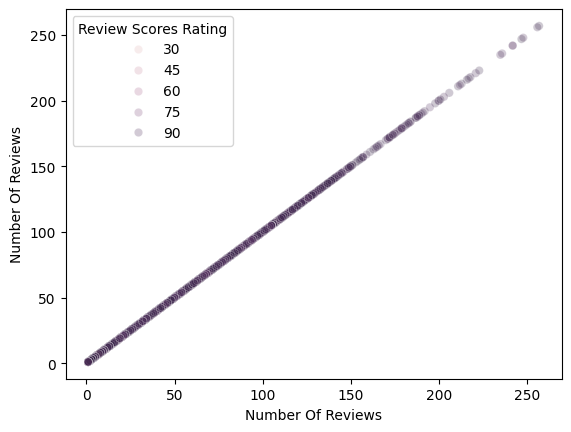

In [15]:
sn.scatterplot(data=df, x="Number Of Reviews", y="Number Of Reviews",hue="Review Scores Rating",alpha=0.25)

<Axes: xlabel='Review Scores Rating (bin)', ylabel='Zipcode'>

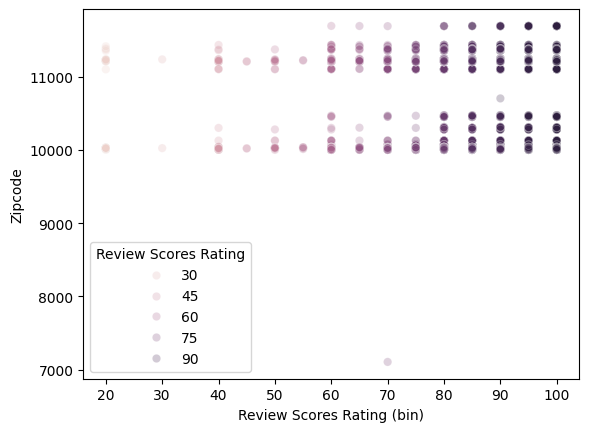

In [16]:
sn.scatterplot(data=df,x="Review Scores Rating (bin)", y="Zipcode",hue="Review Scores Rating",alpha=0.25)

In [17]:
df.shape

(30478, 14)

In [18]:
traget_cols = ['Host Id', 'Review Scores Rating (bin)', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price', 'Review Scores Rating']
y_col = "Number of Records"
y_dl_col = "beds"

In [19]:

# from tensorflow import keras
# from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, r2_score # if the problem is to classify wine quality so your resturant gains competitive advantage on a purchase of next coming wine
# prepare dataset 
X_train, X_test, y_train, y_test = train_test_split(
    df[traget_cols], df[y_col], test_size=0.25, random_state=42)
# create validation dataset 
X_train_train, X_valid_train, y_train_train, y_valid_train = train_test_split(
    X_train[traget_cols], y_train, test_size=0.2, random_state=42)

# # DL: prepare dataset For classification
# X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
#     df[traget_cols], df[y_dl_col], test_size=0.25, random_state=42)
# # create validation dataset 
# X_train_dl_train, X_valid_dl_train, y_train_dl_train, y_valid_dl_train = train_test_split(
#     X_train_dl[traget_cols], y_train_dl, test_size=0.2, random_state=42)


X_train.shape

(22858, 8)

In [20]:
ml_model = RandomForestRegressor()
ml_model.fit(X_train_train, y_train_train)
ml_predict = ml_model.predict(X_valid_train)



In [21]:

# prepare the model
model = keras.Sequential([layers.Dense(16,input_shape=[11]), 
                          layers.Activation("relu"),
                          layers.Dense(16, activation="relu"),
                          layers.Dense(1)])
model.compile(loss="mae", optimizer="adam")
hist = model.fit(X_train_train, y_train_train, batch_size=150, epochs=150, verbose=0)
dl_predict = model.predict(X_valid_train)

NameError: name 'keras' is not defined

In [22]:
checks = pd.DataFrame({"predict": dl_predict.reshape([1, len(y_valid_train)])[0], "true": y_valid_train.values})

NameError: name 'dl_predict' is not defined

In [23]:
plt.scatter(x=checks["true"], y=checks["predict"])

NameError: name 'checks' is not defined

In [21]:

history_df = pd.DataFrame(hist.history)
# Start the plot at epoch 5. You can change this to get a different view.
history_df.loc[5:, ['loss']].plot()

NameError: name 'hist' is not defined

In [22]:
# print("Deep Learning Model Score:",mean_absolute_error(y_valid_train, dl_predict))
# print("Deep Learning Model R2:",r2_score(y_valid_train, dl_predict))

print("RandomForest Model Accuracy:", mean_absolute_error(y_valid_train, ml_predict))
print("RandomForest Model r2_score:", r2_score(y_valid_train, ml_predict))


RandomForest Model Accuracy: 0.0
RandomForest Model r2_score: 1.0


In [26]:

result_df = pd.DataFrame({"ml_pred":ml_predict,"dl_pred": dl_predict.reshape(1, len(dl_predict))[0], "true":y_valid_train})
result_df.loc[:, "result"] = result_df.apply(lambda data: data["dl_pred"] == data["true"], axis=1) 

NameError: name 'dl_predict' is not defined

In [27]:
plt.scatter(x=result_df["true"], y=result_df["dl_pred"])

NameError: name 'result_df' is not defined

In [28]:
plt.scatter(x=result_df["true"], y=result_df["ml_pred"])

NameError: name 'result_df' is not defined

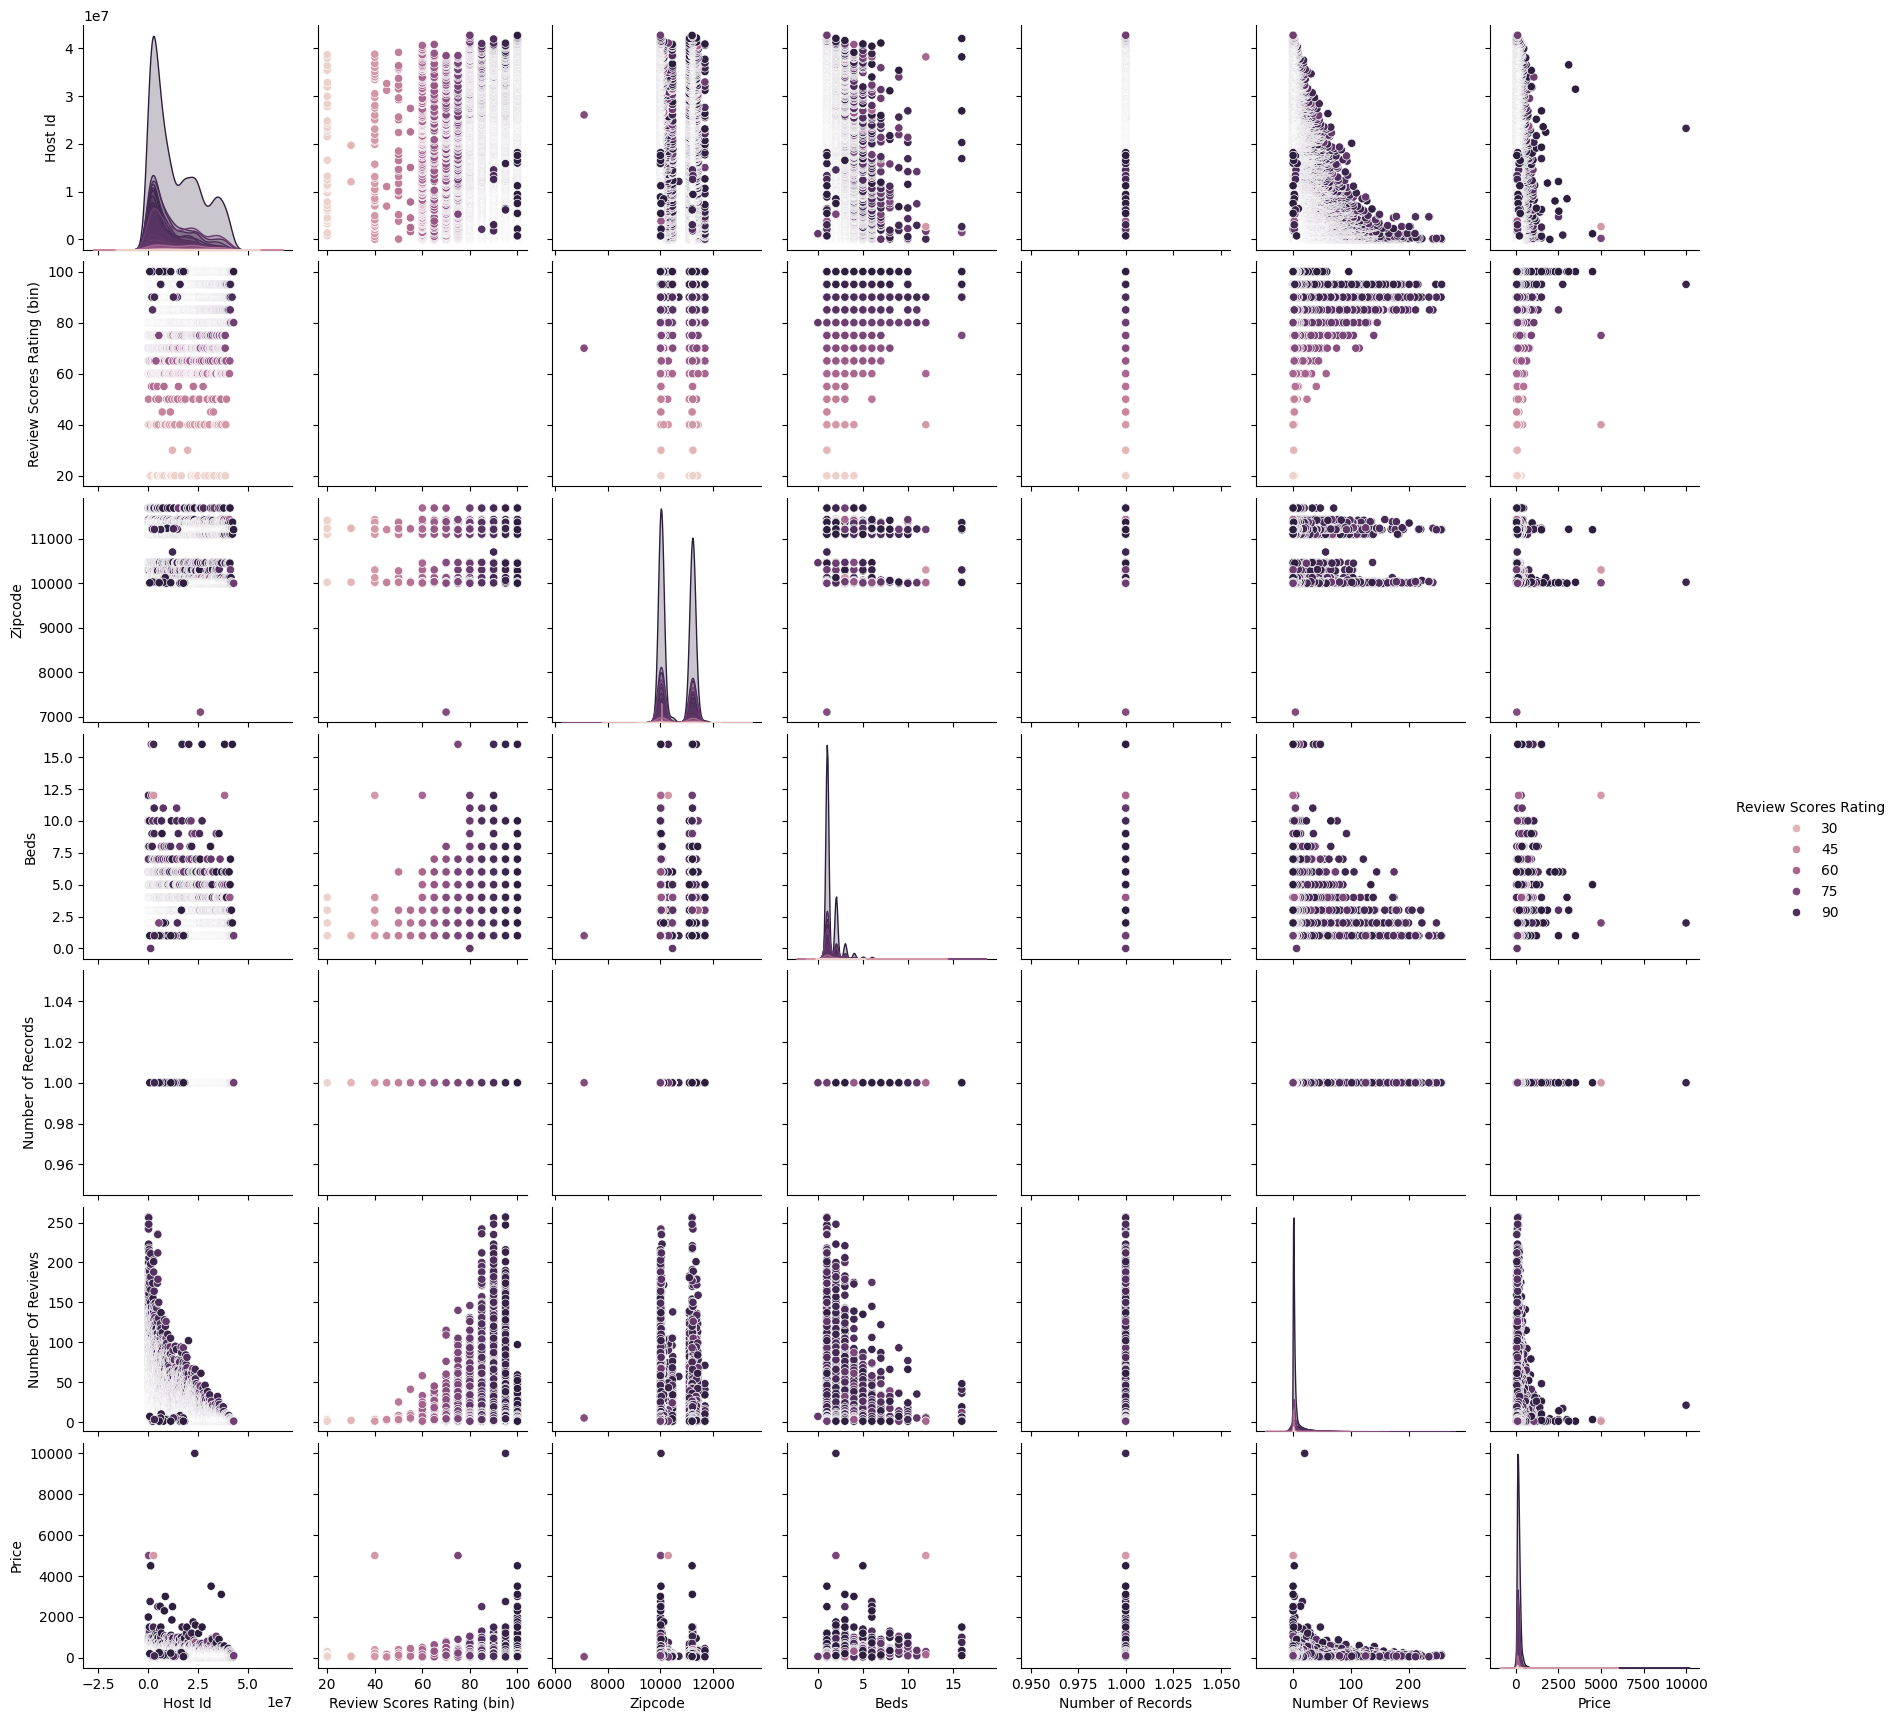

In [29]:
sn.pairplot(df[['Host Id', 'Review Scores Rating (bin)', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price', 'Review Scores Rating']], hue="Review Scores Rating")

In [30]:
potential_features = df.columns
potential_features = potential_features.drop("Host Id")
potential_features = potential_features.drop("Zipcode")

In [35]:
# check relation with quality 
corr_df = df.corr()
corr_df["Review Scores Rating"]

ValueError: could not convert string to float: '1 Bedroom in Prime Williamsburg'

<Axes: xlabel='Review Scores Rating (bin)', ylabel='Zipcode'>

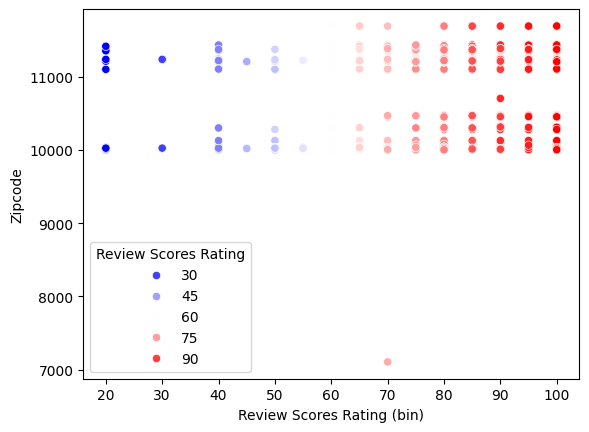

In [36]:
sn.scatterplot(data=df, x="Review Scores Rating (bin)",y="Zipcode",hue="Review Scores Rating", palette="bwr")

<Axes: xlabel='Number of Records', ylabel='Number Of Reviews'>

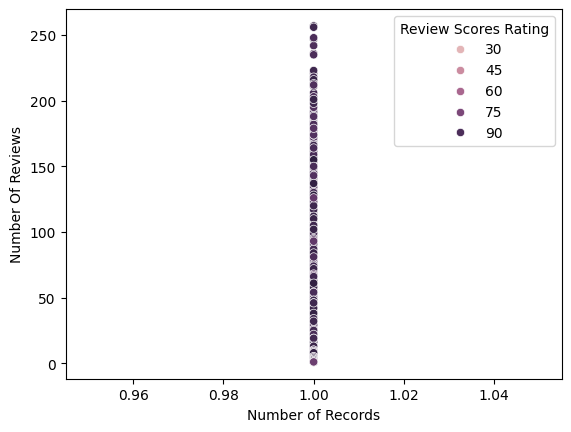

In [37]:
sn.scatterplot(data=df.loc[df["Review Scores Rating"] > 5], x="Number of Records",y="Number Of Reviews",hue="Review Scores Rating")

C:\Users\R\AppData\Local\Temp\ipykernel_4528\2546359728.py:1: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sn.kdeplot(data=df, x="Price",y="Beds",hue="Review Scores Rating",palette="bwr")
C:\Users\R\AppData\Local\Temp\ipykernel_4528\2546359728.py:1: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sn.kdeplot(data=df, x="Price",y="Beds",hue="Review Scores Rating",palette="bwr")
C:\Users\R\AppData\Local\Temp\ipykernel_4528\2546359728.py:1: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sn.kdeplot(data=df, x="Price",y="Beds",hue="Review Scores Rating",palette="bwr")
C:\Users\R\AppData\Local\Temp\ipykernel_4528\2546359728.py:1: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  s

<Axes: xlabel='Price', ylabel='Beds'>

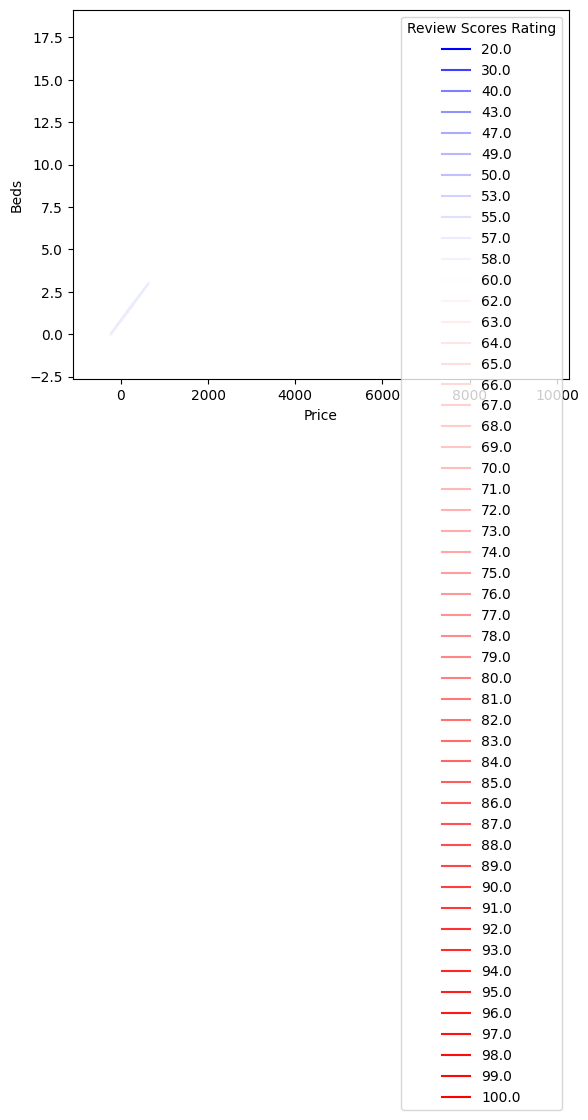

In [38]:
sn.kdeplot(data=df, x="Price",y="Beds",hue="Review Scores Rating",palette="bwr")